In [1]:
# Install necessary libraries
!pip install nltk gensim tensorflow

In [2]:
# Import libraries
import nltk
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer, LancasterStemmer, SnowballStemmer
from nltk import word_tokenize, pos_tag
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


In [3]:
# Download NLTK resources
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [4]:
# Load the dataset
df = pd.read_csv('news.csv')

# Display dataset information
print("Columns available:", df.columns)
print("\nFirst few rows:")
print(df.head())
print(f"\nDataset shape: {df.shape}")

Columns available: Index(['Unnamed: 0', 'title', 'text', 'label'], dtype='object')

First few rows:
   Unnamed: 0                                              title  \
0        8476                       You Can Smell Hillary’s Fear   
1       10294  Watch The Exact Moment Paul Ryan Committed Pol...   
2        3608        Kerry to go to Paris in gesture of sympathy   
3       10142  Bernie supporters on Twitter erupt in anger ag...   
4         875   The Battle of New York: Why This Primary Matters   

                                                text label  
0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
2  U.S. Secretary of State John F. Kerry said Mon...  REAL  
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE  
4  It's primary day in New York and front-runners...  REAL  

Dataset shape: (6335, 4)


<ipython-input-5-2925310057>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='label', palette='Set2')


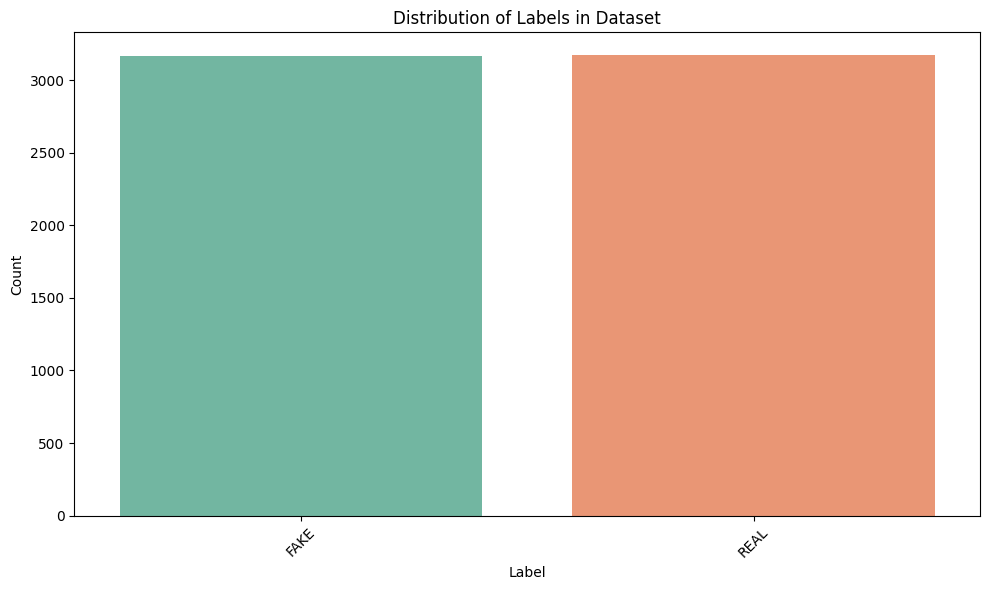


Unique labels: ['FAKE' 'REAL']
Label counts:
label
REAL    3171
FAKE    3164
Name: count, dtype: int64


In [5]:
# Function to plot label distribution
def plot_label_distribution(df):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='label', palette='Set2')
    plt.title('Distribution of Labels in Dataset')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot label distribution
if 'label' in df.columns:
    plot_label_distribution(df)
    print(f"\nUnique labels: {df['label'].unique()}")
    print(f"Label counts:\n{df['label'].value_counts()}")
else:
    print("No 'label' column found for visualization.")

In [6]:
# Text cleaning function
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with single space
    text = text.strip()
    return text

# Tokenization and stopword removal
stop_words = set(stopwords.words('english'))
def tokenize_and_remove_stopwords(text):
    if not text:
        return []
    tokens = word_tokenize(text)
    filtered = [word for word in tokens if word not in stop_words and len(word) > 2]
    return filtered

# Stemming function
def apply_stemming(words):
    if not words:
        return []
    porter = PorterStemmer()
    lancaster = LancasterStemmer()
    snowball = SnowballStemmer('english')

    return {
        'original': words,
        'porter': [porter.stem(word) for word in words],
        'lancaster': [lancaster.stem(word) for word in words],
        'snowball': [snowball.stem(word) for word in words]
    }

# Lemmatization function
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_text(text):
    if not text:
        return ""
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    return ' '.join(lemmatized)

# Full preprocessing function
def full_preprocess(text):
    text = clean_text(text)
    tokens = tokenize_and_remove_stopwords(text)
    text = ' '.join(tokens)
    text = lemmatize_text(text)
    return text

# Apply preprocessing
if 'text' in df.columns:
    print("\nProcessing text...")
    df['processed_text'] = df['text'].apply(full_preprocess)
    # Remove empty processed texts
    df = df[df['processed_text'].str.len() > 0].reset_index(drop=True)
    print("\nPreprocessing complete. Sample results:")
    print(df[['text', 'processed_text']].head())
    print(f"Dataset shape after preprocessing: {df.shape}")
else:
    print("Error: 'text' column not found in the dataframe.")
    exit()


Processing text...

Preprocessing complete. Sample results:
                                                text  \
0  Daniel Greenfield, a Shillman Journalism Fello...   
1  Google Pinterest Digg Linkedin Reddit Stumbleu...   
2  U.S. Secretary of State John F. Kerry said Mon...   
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...   
4  It's primary day in New York and front-runners...   

                                      processed_text  
0  daniel greenfield shillman journalism fellow f...  
1  google pinterest digg linkedin reddit stumbleu...  
2  secretary state john kerry say monday stop par...  
3  kaydee king kaydeeking november lesson tonight...  
4  primary day new york frontrunners hillary clin...  
Dataset shape after preprocessing: (6298, 5)


In [7]:
# One-Hot Encoding for Labels
if 'label' in df.columns:
    print("\nPerforming One-Hot Encoding on labels...")
    label_encoder = LabelEncoder()
    df['label_encoded'] = label_encoder.fit_transform(df['label'])
    df_onehot = pd.get_dummies(df['label'], prefix='label')
    df = pd.concat([df, df_onehot], axis=1)

    print("Label encoding mapping:")
    for i, label in enumerate(label_encoder.classes_):
        print(f"{label}: {i}")

    print(f"\nOne-hot encoded columns: {df_onehot.columns.tolist()}")

# Save processed data
processed_filename = 'processed_news.csv'
df.to_csv(processed_filename, index=False)
print(f"\nProcessed data saved to {processed_filename}")


Performing One-Hot Encoding on labels...
Label encoding mapping:
FAKE: 0
REAL: 1

One-hot encoded columns: ['label_FAKE', 'label_REAL']

Processed data saved to processed_news.csv


<ipython-input-24-4245875485>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


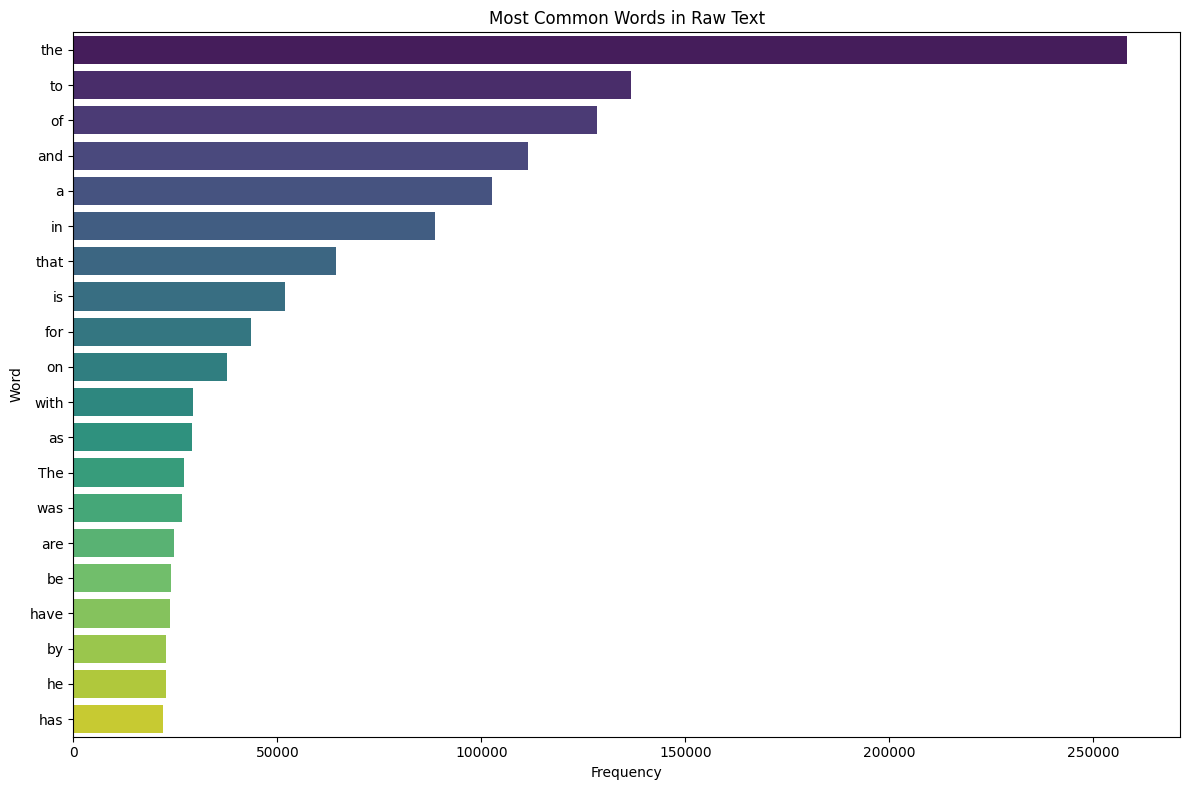

<ipython-input-24-4245875485>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


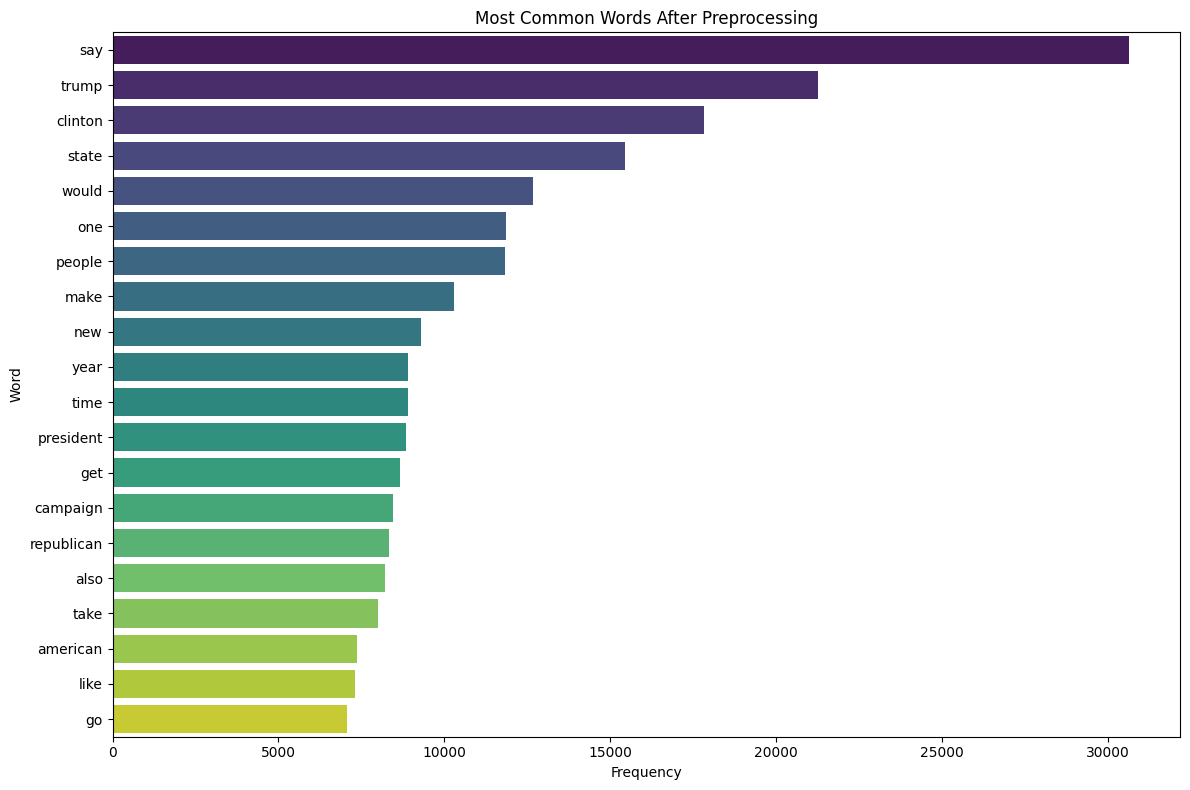

In [24]:
# Plot word frequency
def plot_word_frequency(text_column, title):
    all_words = ' '.join(text_column).split()
    word_counts = Counter(all_words)
    common_words = word_counts.most_common(20)

    if not common_words:
        print(f"No words found for {title}")
        return

    words, counts = zip(*common_words)

    plt.figure(figsize=(12, 8))
    sns.barplot(x=list(counts), y=list(words), palette='viridis')
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.tight_layout()
    plt.show()

# Plot word frequencies before and after preprocessing
plot_word_frequency(df['text'], 'Most Common Words in Raw Text')
plot_word_frequency(df['processed_text'], 'Most Common Words After Preprocessing')

In [9]:
# Word2Vec Implementation
print("\nTraining Word2Vec model...")
# Prepare sentences for Word2Vec (list of lists of words)
sentences = [text.split() for text in df['processed_text'] if text]

# Train Word2Vec model
word2vec_model = Word2Vec(
    sentences=sentences,
    vector_size=100,  # Dimensionality of word vectors
    window=5,         # Context window size
    min_count=2,      # Minimum word frequency
    workers=4,        # Number of worker threads
    sg=1              # Skip-gram model
)

print(f"Word2Vec vocabulary size: {len(word2vec_model.wv.key_to_index)}")

# Function to create document vectors using Word2Vec
def get_word2vec_features(texts, model, vector_size=100):
    features = []
    for text in texts:
        words = text.split()
        word_vectors = []
        for word in words:
            if word in model.wv:
                word_vectors.append(model.wv[word])

        if word_vectors:
            # Average word vectors to get document vector
            doc_vector = np.mean(word_vectors, axis=0)
        else:
            # Zero vector if no words found in vocabulary
            doc_vector = np.zeros(vector_size)

        features.append(doc_vector)

    return np.array(features)


Training Word2Vec model...
Word2Vec vocabulary size: 39861


In [29]:
# Model training and evaluation with TF-IDF
if 'label' in df.columns:
    from sklearn.model_selection import train_test_split
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import classification_report, accuracy_score
    from sklearn.metrics import confusion_matrix

    print("\n" + "="*50)
    print("TF-IDF + Logistic Regression")
    print("="*50)

    # TF-IDF Vectorization
    tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
    X_tfidf = tfidf_vectorizer.fit_transform(df['processed_text'])
    y = df['label_encoded']

    # Train-test split
    X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(
        X_tfidf, y, test_size=0.2, random_state=42, stratify=y
    )

    # Train classifier
    clf_tfidf = LogisticRegression(max_iter=1000, random_state=42)
    clf_tfidf.fit(X_train_tfidf, y_train)

    # Evaluate
    y_pred_tfidf = clf_tfidf.predict(X_test_tfidf)
    tfidf_accuracy = accuracy_score(y_test, y_pred_tfidf)

    print(f"TF-IDF + Logistic Regression Accuracy: {tfidf_accuracy:.4f}")
    print("\nClassification Report (TF-IDF):")
    print(classification_report(y_test, y_pred_tfidf, target_names=label_encoder.classes_))

    # Word2Vec + Logistic Regression
    print("\n" + "="*50)
    print("Word2Vec + Logistic Regression")
    print("="*50)

    X_w2v = get_word2vec_features(df['processed_text'], word2vec_model)
    X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(
        X_w2v, y, test_size=0.2, random_state=42, stratify=y
    )

    # Train classifier with Word2Vec features
    clf_w2v = LogisticRegression(max_iter=1000, random_state=42)
    clf_w2v.fit(X_train_w2v, y_train_w2v)

    # Evaluate
    y_pred_w2v = clf_w2v.predict(X_test_w2v)
    w2v_accuracy = accuracy_score(y_test_w2v, y_pred_w2v)

    print(f"Word2Vec + Logistic Regression Accuracy: {w2v_accuracy:.4f}")
    print("\nClassification Report (Word2Vec):")
    print(classification_report(y_test_w2v, y_pred_w2v, target_names=label_encoder.classes_))

    # Comparison
    print("\n" + "="*50)
    print("COMPARISON: TF-IDF vs Word2Vec")
    print("="*50)
    print(f"TF-IDF Accuracy:    {tfidf_accuracy:.4f}")
    print(f"Word2Vec Accuracy:  {w2v_accuracy:.4f}")
    print(f"Difference:         {abs(tfidf_accuracy - w2v_accuracy):.4f}")

    if tfidf_accuracy > w2v_accuracy:
        print("TF-IDF performs better!")
    elif w2v_accuracy > tfidf_accuracy:
        print("Word2Vec performs better!")
    else:
        print("Both methods perform equally!")

else:
    print("\nWarning: 'label' column not found. Skipping model training.")


TF-IDF + Logistic Regression
TF-IDF + Logistic Regression Accuracy: 0.9294

Classification Report (TF-IDF):
              precision    recall  f1-score   support

        FAKE       0.91      0.95      0.93       626
        REAL       0.95      0.91      0.93       634

    accuracy                           0.93      1260
   macro avg       0.93      0.93      0.93      1260
weighted avg       0.93      0.93      0.93      1260


Word2Vec + Logistic Regression
Word2Vec + Logistic Regression Accuracy: 0.8937

Classification Report (Word2Vec):
              precision    recall  f1-score   support

        FAKE       0.89      0.90      0.89       626
        REAL       0.90      0.89      0.89       634

    accuracy                           0.89      1260
   macro avg       0.89      0.89      0.89      1260
weighted avg       0.89      0.89      0.89      1260


COMPARISON: TF-IDF vs Word2Vec
TF-IDF Accuracy:    0.9294
Word2Vec Accuracy:  0.8937
Difference:         0.0357
TF-IDF pe

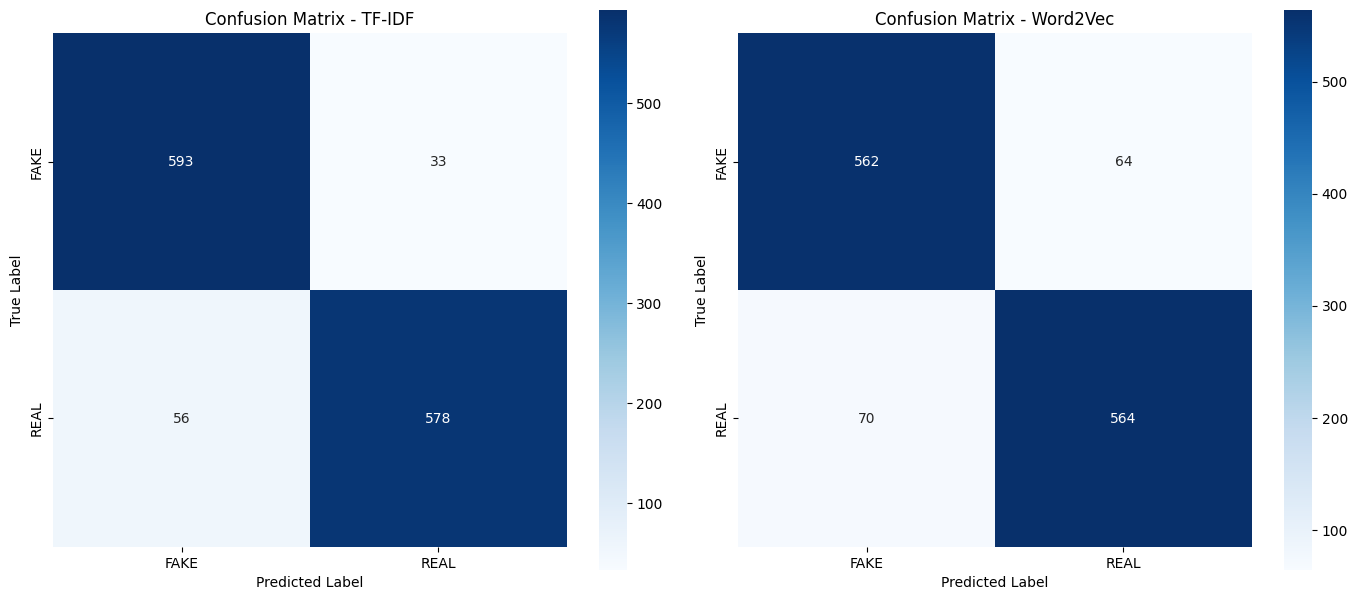

In [11]:
# Confusion matrix function
def plot_confusion_matrix(y_true, y_pred, labels, title, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(f'Confusion Matrix - {title}')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_aspect('equal')

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot confusion matrices
if 'label' in df.columns and 'processed_text' in df.columns:
    plot_confusion_matrix(y_test, y_pred_tfidf, label_encoder.classes_, "TF-IDF", axes[0])
    plot_confusion_matrix(y_test_w2v, y_pred_w2v, label_encoder.classes_, "Word2Vec", axes[1])

# Show the plots
plt.tight_layout()
plt.show()


<ipython-input-12-1284410311>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_scores, y=top_features, palette='Blues')


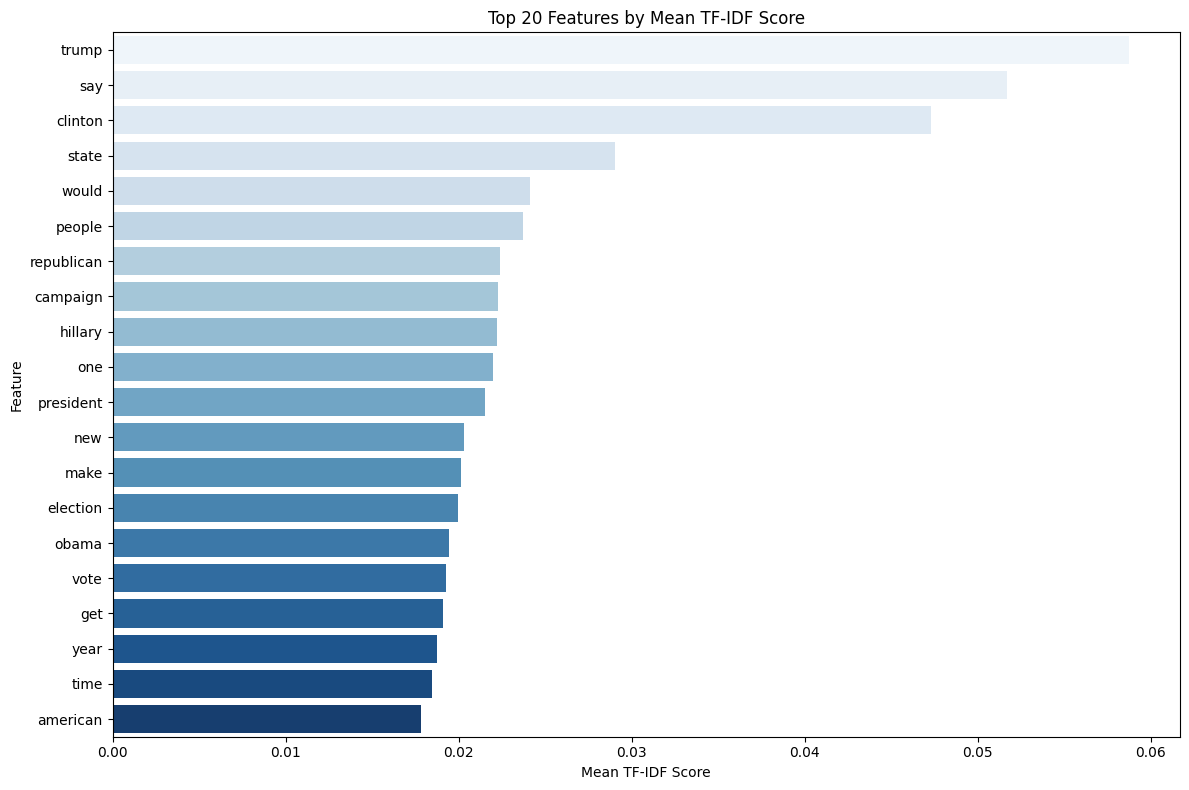

In [12]:
# Visualize top TF-IDF features
def plot_top_tfidf_features(vectorizer, n=20):
    feature_names = vectorizer.get_feature_names_out()
    # Get average TF-IDF scores across all documents
    mean_scores = np.asarray(X_tfidf.mean(axis=0)).flatten()

    # Get top features by mean TF-IDF score
    top_indices = mean_scores.argsort()[-n:][::-1]
    top_features = [feature_names[i] for i in top_indices]
    top_scores = [mean_scores[i] for i in top_indices]

    plt.figure(figsize=(12, 8))
    sns.barplot(x=top_scores, y=top_features, palette='Blues')
    plt.title(f'Top {n} Features by Mean TF-IDF Score')
    plt.xlabel('Mean TF-IDF Score')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

# Plot top 20 TF-IDF features
if 'X_tfidf' in locals():
    plot_top_tfidf_features(tfidf_vectorizer)

In [30]:
# LSTM Implementation
print("\n" + "="*50)
print("LSTM Neural Network")
print("="*50)

# Prepare data for LSTM
max_words = 10000
max_len = 200

# Tokenizer for LSTM
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['processed_text'])

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(df['processed_text'])
X_lstm = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# Prepare labels for LSTM
y_lstm = to_categorical(df['label_encoded'], num_classes=len(label_encoder.classes_))

# Train-test split for LSTM
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    X_lstm, y_lstm, test_size=0.2, random_state=42, stratify=df['label_encoded']
)

print(f"LSTM input shape: {X_train_lstm.shape}")
print(f"LSTM output shape: {y_train_lstm.shape}")

# Build LSTM model
def create_lstm_model(vocab_size, embedding_dim, max_length, num_classes):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        LSTM(128, return_sequences=True, dropout=0.5, recurrent_dropout=0.5),
        LSTM(64, dropout=0.5, recurrent_dropout=0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create and train LSTM model
embedding_dim = 100
num_classes = len(label_encoder.classes_)

lstm_model = create_lstm_model(max_words, embedding_dim, max_len, num_classes)

print("\nLSTM Model Architecture:")
lstm_model.summary()

# Train the model
print("\nTraining LSTM model...")
history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    batch_size=32,
    epochs=10,
    validation_data=(X_test_lstm, y_test_lstm),
    verbose=1
)

# Evaluate LSTM model
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_lstm, y_test_lstm, verbose=0)
print(f"\nLSTM Test Accuracy: {lstm_accuracy:.4f}")



LSTM Neural Network
LSTM input shape: (5038, 200)
LSTM output shape: (5038, 2)

LSTM Model Architecture:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Training LSTM model...
Epoch 1/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 144s 852ms/step - accuracy: 0.6009 - loss: 0.6661 - val_accuracy: 0.7889 - val_loss: 0.5243
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 148s 886ms/step - accuracy: 0.7658 - loss: 0.5569 - val_accuracy: 0.7833 - val_loss: 0.5214
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 134s 838ms/step - accuracy: 0.7534 - loss: 0.5647 - val_accuracy: 0.8024 - val_loss: 0.4856
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 132s 837ms/step - accuracy: 0.7478 - loss: 0.5528 - val_accuracy: 0.7643 - val_loss: 0.4954
Epoch 5/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 146s 865ms/step - accuracy: 0.7803 - loss: 0.4994 - val_accuracy: 0.8333 - val_loss: 0.4268
Epoch 6/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 142s 865ms/step - accuracy: 0.8338 - loss: 0.4244 - val_accuracy: 0.8611 - val_loss: 0.3879
Epoch 7/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 141s 862ms/step - accuracy: 0.8274 - loss: 0.3659 - val_accuracy: 0.7865 - val_loss: 0.5353
Epoch 8/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 133s 840ms/s

In [21]:
# Get LSTM predictions
y_pred_lstm_prob = lstm_model.predict(X_test_lstm)
y_pred_lstm = np.argmax(y_pred_lstm_prob, axis=1)
y_test_lstm_labels = np.argmax(y_test_lstm, axis=1)

print("\nClassification Report (LSTM):")
print(classification_report(y_test_lstm_labels, y_pred_lstm, target_names=label_encoder.classes_))


40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 177ms/step

Classification Report (LSTM):
              precision    recall  f1-score   support

        FAKE       0.87      0.80      0.83       626
        REAL       0.82      0.88      0.85       634

    accuracy                           0.84      1260
   macro avg       0.84      0.84      0.84      1260
weighted avg       0.84      0.84      0.84      1260



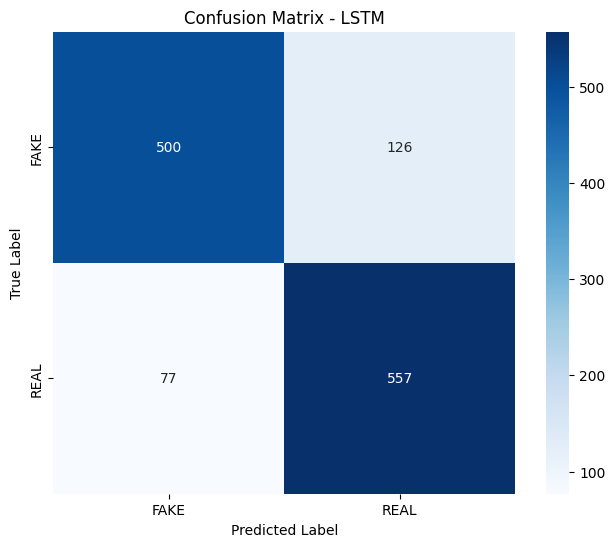

In [20]:
# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Call the function with ax as the parameter
plot_confusion_matrix(y_test_lstm_labels, y_pred_lstm, label_encoder.classes_, "LSTM", ax)

# Show the plot
plt.show()

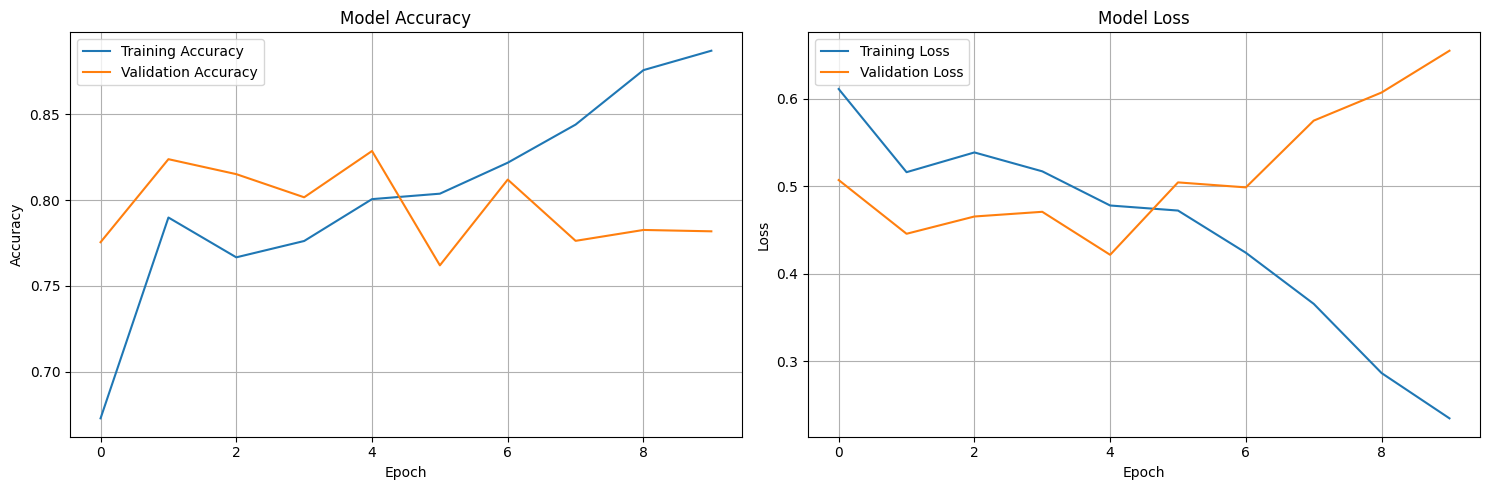

In [16]:
# Plot training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [17]:
# Final Comparison of All Methods
print("\n" + "="*60)
print("FINAL MODEL COMPARISON")
print("="*60)
print(f"TF-IDF + Logistic Regression:  {tfidf_accuracy:.4f}")
print(f"Word2Vec + Logistic Regression: {w2v_accuracy:.4f}")
print(f"LSTM Neural Network:           {lstm_accuracy:.4f}")
print("="*60)

# Determine best model
accuracies = {
    'TF-IDF + LogReg': tfidf_accuracy,
    'Word2Vec + LogReg': w2v_accuracy,
    'LSTM': lstm_accuracy
}

best_model = max(accuracies, key=accuracies.get)
print(f"Best performing model: {best_model} with accuracy: {accuracies[best_model]:.4f}")

# Show sample predictions from best model
print(f"\nSample predictions from {best_model}:")
sample_indices = np.random.choice(len(X_test_lstm), 5, replace=False)

for i, idx in enumerate(sample_indices):
    if best_model == 'LSTM':
        pred_idx = y_pred_lstm[idx]
    elif best_model == 'TF-IDF + LogReg':
        pred_idx = y_pred_tfidf[idx]
    else:  # Word2Vec
        pred_idx = y_pred_w2v[idx]

    true_idx = y_test_lstm_labels[idx]

    original_text = df.iloc[X_test_lstm.shape[0] + idx]['text'][:200] + "..."

    print(f"\nSample {i+1}:")
    print(f"Text: {original_text}")
    print(f"True Label: {label_encoder.classes_[true_idx]}")
    print(f"Predicted Label: {label_encoder.classes_[pred_idx]}")
    print(f"Correct: {'✓' if true_idx == pred_idx else '✗'}")



FINAL MODEL COMPARISON
TF-IDF + Logistic Regression:  0.9294
Word2Vec + Logistic Regression: 0.8937
LSTM Neural Network:           0.7817
Best performing model: TF-IDF + LogReg with accuracy: 0.9294

Sample predictions from TF-IDF + LogReg:

Sample 1:
Text: While the United States sits on the edge of its collective seat as Donald Trump gains an electoral vote majority in his bid for the White House, its neighbor to the north seems to be getting a little ...
True Label: REAL
Predicted Label: REAL
Correct: ✓

Sample 2:
Text: It’s a curious feature of American life that when four innocents are killed by a gunman in Chattanooga, or when a young white supremacist opens fire inside a historic AME Church in Charleston, we talk...
True Label: FAKE
Predicted Label: FAKE
Correct: ✓

Sample 3:
Text: Swiss volunteer firefighters: It’s ok to be a bit tipsy when reporting for duty Published time: 26 Oct, 2016 23:00 Get short URL A Swiss firefighter helps a volunteer during a save and rescue drill i